In [1]:
from pathlib import Path
import joblib
import numpy as np

from cogpred.utils.naming import make_run_path
from cogpred.utils.configuration import get_config
from cogpred.loading import make_test_data, make_training_data

config = get_config()
dir = Path(config["output_dir"]) / "prediction"
ATLAS = "schaefer200"
k = 3

conn_dir = config["connectivity_matrices"]

fc_exps = [
    "k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default",
    #"k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default_smote-False",
    #"k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default_smote-True",
    #"k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default_smote-minority",
    #"k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-ContDefaultDorsAttnLimbicSalVentAttnSomMotVis_inter-ContDefaultDorsAttnLimbicSalVentAttnSomMotVis"
    "k-3_feat-fc_atlas-msdl_net-all"
]
volumetry = [
    "k-3_feat-volumetry_atlas-schaefer200_experimental-False"
]

series_exp = [
    #"k-3_feat-series_experimental-True_atlas-schaefer200_winsize-96_batchsize-32_niter-10_stamp-2024-07-15-17:47"
    #"k-3_feat-series_experimental-True_atlas-schaefer200_winsize-96_batchsize-64_niter-10_stamp-2024-07-16-12:07"
    #"k-3_feat-series_experimental-True_atlas-schaefer200_winsize-12_batchsize-64_niter-10_stamp-2024-07-17-12:03",
    "k-3_feat-series_experimental-True_atlas-schaefer200_winsize-24_batchsize-64_niter-10_stamp-2024-07-16-15:02",
    #"k-3_feat-series_experimental-True_atlas-schaefer200_winsize-36_batchsize-64_niter-10_stamp-2024-07-17-12:58",
    #"k-3_feat-series_experimental-True_atlas-schaefer200_winsize-48_batchsize-64_niter-10_stamp-2024-07-17-12:49"
]

matrices, metadata = make_test_data(conn_dir, ATLAS, k)
y_test = metadata.cluster_label.values.astype(int)

Dropping 3 subjects because of lacking MMMSE


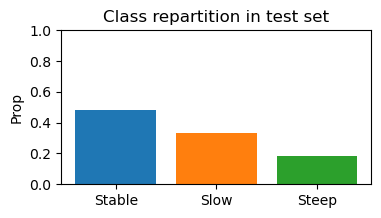

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
classes = ["Stable", "Slow", "Steep"]
_, counts = np.unique(y_test, return_counts=True)
plt.subplots(figsize=(4, 2))
plt.bar(
    classes,
    counts / len(y_test),
    color=sns.color_palette()[:3],
)
plt.ylabel("Prop")
plt.ylim(0, 1)
plt.title("Class repartition in test set")
plt.show()

In [3]:
import json
from sklearn.metrics import f1_score, balanced_accuracy_score
from sklearn.dummy import DummyClassifier
from cogpred.features import make_features
from cogpred.loading import TSFetcher
from cogpred.models import WindowNetClassifier, BOLDCNN
from torch import nn
from neuroginius.atlas import Atlas
from cogpred.models import default_channel_func, initial_bump, slow_increase, fast_increase, constant_channels

TSPATH = Path("/georges/memento/BIDS/derivatives/schaeffer200_merged_phenotypes")

def evaluate_series_model(expname):
    
    # Fetch features
    atlas = Atlas.from_name(ATLAS)
    fetcher = TSFetcher(TSPATH)
    
    # TODO Systematic selection
    #net_indexer = np.full((len(atlas.macro_labels,)), True)
    net_indexer = np.where(np.array(atlas.macro_labels) == "Default", True, False)
    exppath = dir / expname
    features = make_features(fetcher, metadata, net_indexer)

    # Rebuild model
    with open(exppath / "architecture.json", "r") as file:
        params = json.load(file)

    params["module__channel_func"] = eval(params["module__channel_func"])

    expdict = dict()
    for k in exppath.name.split("_"):
        exptag = k.split("-")
        expdict[exptag[0]] = exptag[1]
    new_net = WindowNetClassifier(
        module=BOLDCNN,
        module__n_channels=sum(net_indexer),
        module__window_size=int(expdict["winsize"]),
        criterion=nn.CrossEntropyLoss(),
        **params
    )
    new_net.initialize()  # This is important!
    new_net.load_params(f_params=exppath / "params.pkl")

    # Run preds and return score
    y_pred = []
    for ts in features:
        ts = ts.T
        ts = ts.reshape(1, *ts.shape)
        p, _ = new_net.sliding_inference(ts, stride=6)
        integral = p.sum(axis=1)
        decision = np.argmax(integral)
        y_pred.append(decision)

    return y_test, np.array(y_pred)
    

def evaluate_fc_model(expname):
    estimator = joblib.load(dir / expname / "best_estimator.joblib")
    y_pred = estimator.predict(matrices)
    return y_test, y_pred

def evaluate_dummy_model():
    X_mock = np.ones(len(y_test))
    dum_pred = DummyClassifier(strategy="most_frequent").fit(X_mock, y_test).predict(X_mock)
    return y_test, dum_pred

    

In [4]:
from cogpred.supervised import macro_f1
from functools import partial
from sklearn.metrics import f1_score, balanced_accuracy_score, ConfusionMatrixDisplay

f1 = partial(f1_score, average="macro")

rng = np.random.default_rng(seed=1234)
def bootstrap_predictions(y_test, y_pred, B=2000, metric=f1):
    dist = []
    s_true = balanced_accuracy_score(y_test, y_pred)
    for _ in range(B):
        idx_sampled = rng.integers(0, y_test.size, size=y_test.size)
        s_i = metric(
            y_test[idx_sampled],
            y_pred[idx_sampled]
        )
        dist.append(s_i)
    return s_true, np.stack(dist)
        

In [5]:
import numpy as np

y_test, y_pred = evaluate_dummy_model()
score, dist = bootstrap_predictions(y_test, y_pred)
res = {
    "dummy": {
        "score": score,
        "dist": dist,
        "y_pred": y_pred
    }
}

for fc_exp in fc_exps:
    atlas_name = fc_exp.split("_")[2].split("-")[1]
    matrices, metadata = make_test_data(conn_dir, atlas_name, k)
    y_test, y_pred = evaluate_fc_model(fc_exp)
    res[fc_exp] = dict()
    res[fc_exp]["y_pred"] = y_pred
    res[fc_exp]["score"], res[fc_exp]["dist"] = bootstrap_predictions(y_test, y_pred)

for ts_exp in series_exp:
    y_test, y_pred = evaluate_series_model(ts_exp)
    res[ts_exp] = dict()
    res[ts_exp]["y_pred"] = y_pred
    res[ts_exp]["score"], res[ts_exp]["dist"] = bootstrap_predictions(y_test, y_pred)



Dropping 3 subjects because of lacking MMMSE
Dropping 3 subjects because of lacking MMMSE
46 24
92 12
184 6
138 3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


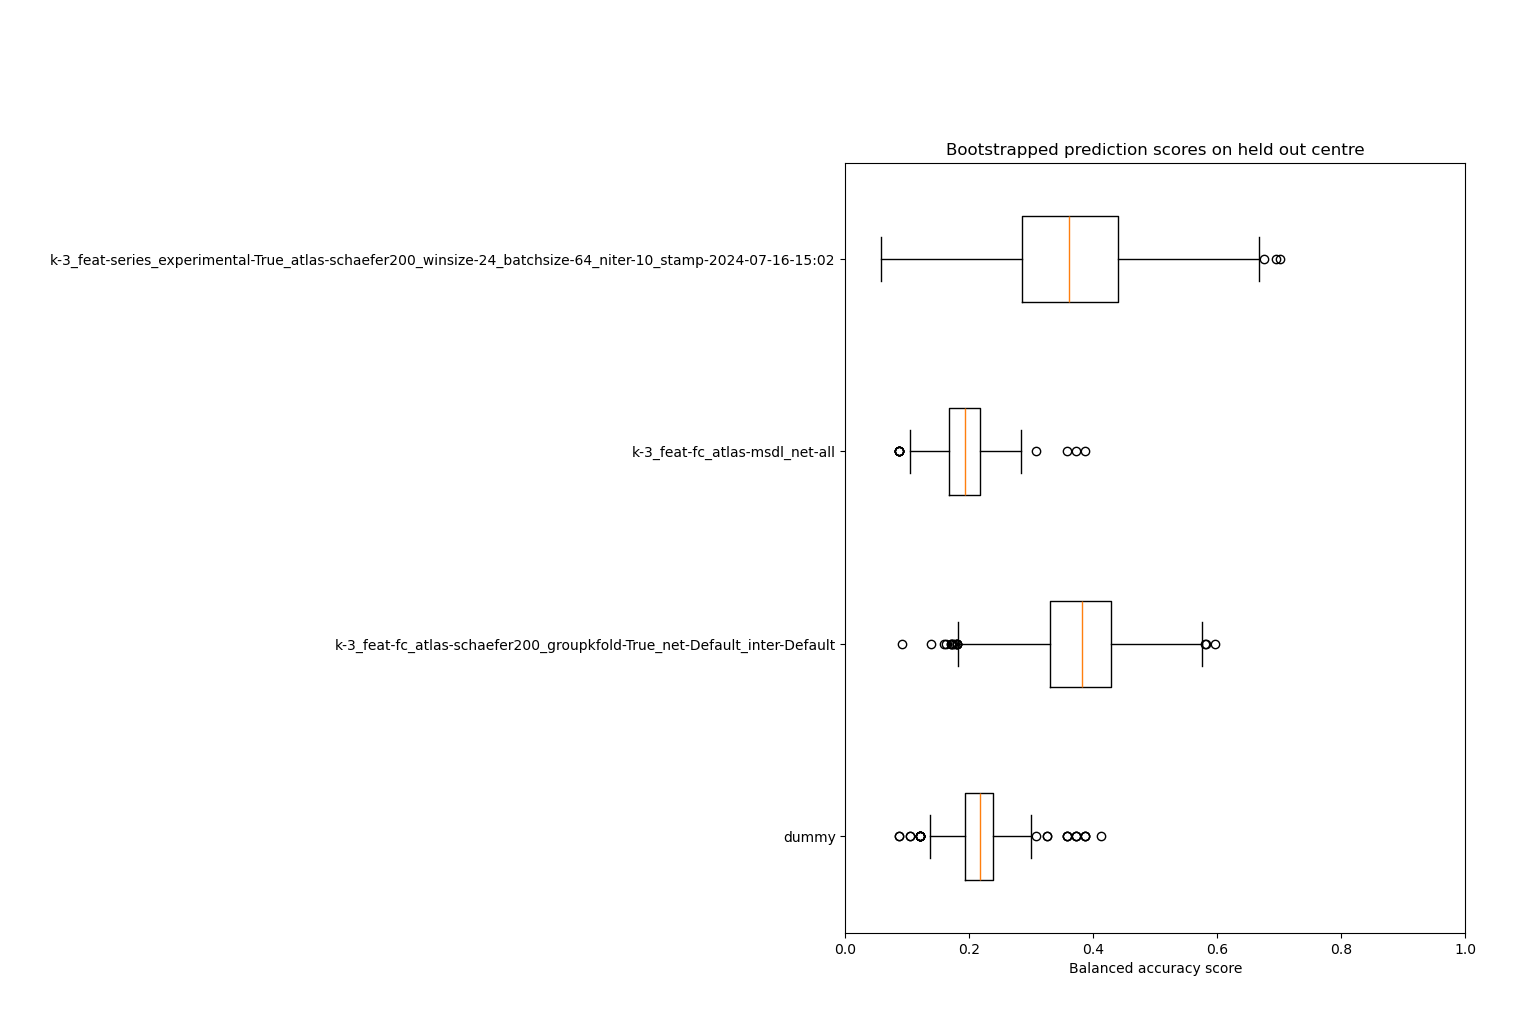

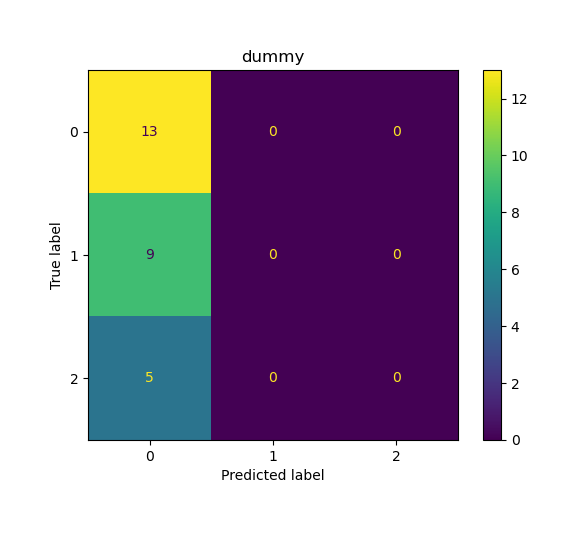

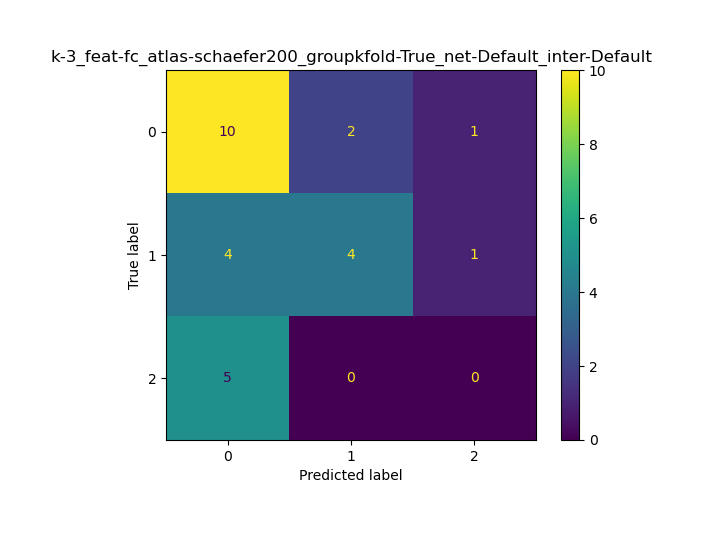

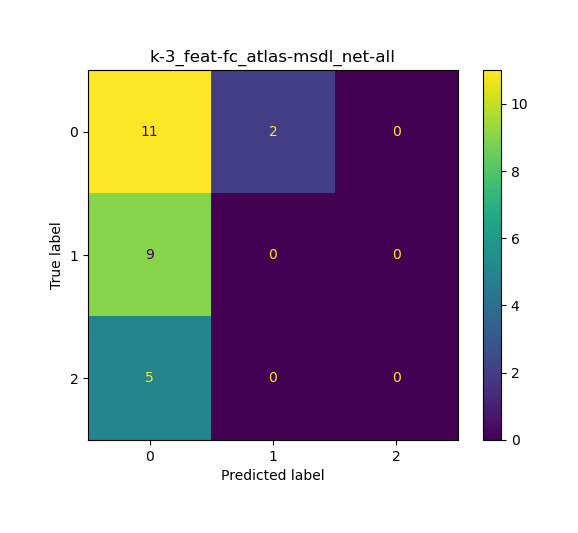

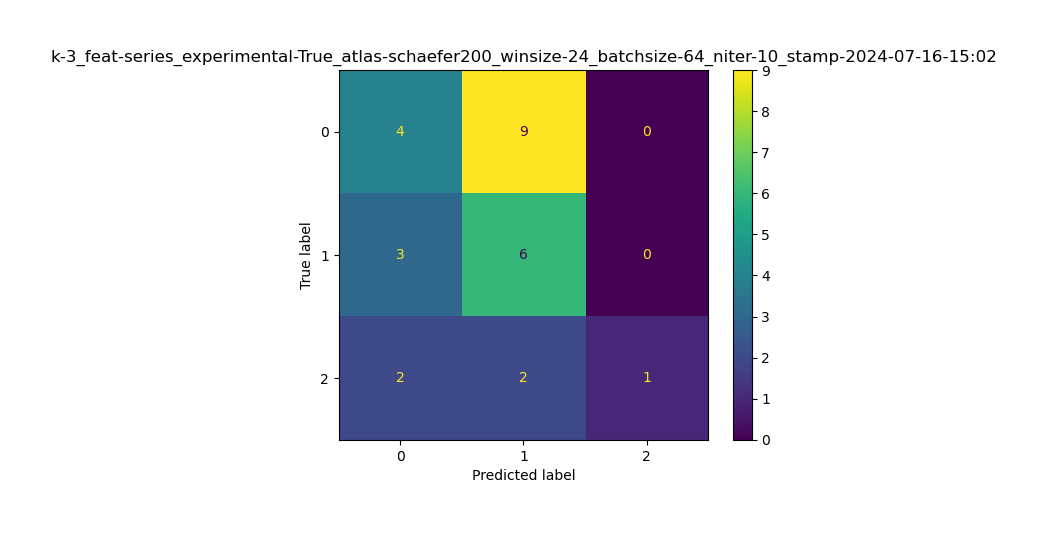

In [6]:
fig, axes = plt.subplots(figsize=(8, 10))
dists = []
labels = []
for model, resdict in res.items():
    dists.append(resdict["dist"])
    labels.append(model)
    #axes.hist(resdict["dist"], alpha=0.4, label=model[9:])

    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, resdict["y_pred"]#, labels=classes
    )
    disp.ax_.set_title(model)

axes.boxplot(dists, labels=labels, vert=False)
axes.set_xlabel(f"Balanced accuracy score")
axes.set_title("Bootstrapped prediction scores on held out centre")
axes.set_xlim(0, 1)
#fig.legend(loc="lower left")
fig.legend(bbox_to_anchor=(0, 1.0), loc='upper left')
#fig.legend()
plt.show()

In [7]:
import statsmodels.formula.api as smf

metadata["model_predictions"] = res["k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default_smote-False"]["y_pred"]

model_confounds = smf.mnlogit("cluster_label ~ SEX", metadata.reset_index()).fit()
model_pred = smf.mnlogit("cluster_label ~ model_predictions", metadata.reset_index()).fit()
model_full = smf.mnlogit("cluster_label ~ SEX + model_predictions", metadata.reset_index()).fit()

r2_full = model_full.prsquared
r2_c = model_confounds.prsquared
r2_p = model_pred.prsquared
r2_p_c = r2_full - r2_c - r2_p

KeyError: 'k-3_feat-fc_atlas-schaefer200_groupkfold-True_net-Default_inter-Default_smote-False'

In [ ]:
print(model_full.summary())

                          MNLogit Regression Results                          
Dep. Variable:          cluster_label   No. Observations:                   27
Model:                        MNLogit   Df Residuals:                       21
Method:                           MLE   Df Model:                            4
Date:                Wed, 17 Jul 2024   Pseudo R-squ.:                 0.08765
Time:                        12:41:08   Log-Likelihood:                -25.383
converged:                       True   LL-Null:                       -27.821
Covariance Type:            nonrobust   LLR p-value:                    0.3002
  cluster_label=1       coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.9175      0.682     -1.345      0.179      -2.254       0.419
SEX[T.Masculin]       0.2443      0.915      0.267      0.789      -1.549       2.038
model_predictions     0.

In [ ]:
r2_c

0.04853035403332928

In [ ]:
r2_p

0.04112304268603517

In [ ]:
r2_p_c

-0.002005629194611558

<Axes: xlabel='cluster_label', ylabel='count'>

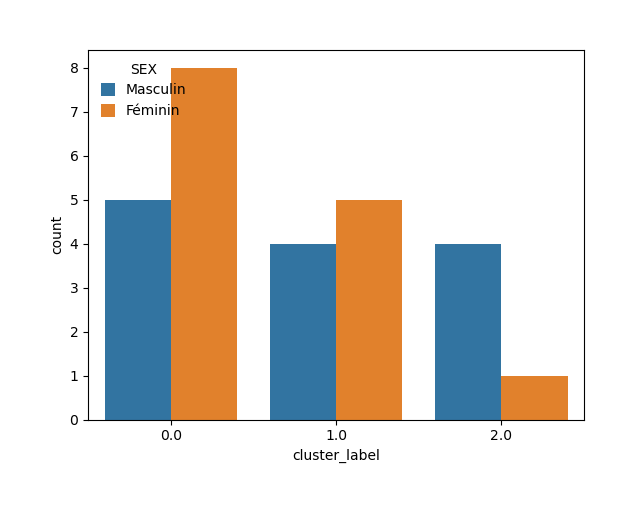

In [ ]:
import seaborn as sns

sns.countplot(metadata, x="cluster_label", hue="SEX")